# Contrastive Learning

### Data preparation

Installing the necessary libraries

In [1]:
%%capture
!pip install torch torchvision

Importing the necessary libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

Different data transformations and loading the dataset

In [3]:
%%capture
# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Usual transformations
transform_load = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Data augmentation
transform_augmented = transforms.Compose([
        transforms.RandomResizedCrop(size=224 ,scale=(0.2, 1.0), ratio=(0.75, 1.25)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(brightness=0.9, contrast=0.9,
                                  saturation=0.9, hue=0.1),
        transforms.GaussianBlur(3)
    ])

# Get the subset dataset and calculate the mean and std
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_load)
train_size = 10000
subset_indices = np.random.choice(len(train_dataset), train_size, replace=False)
subset_dataset = torch.utils.data.Subset(train_dataset, subset_indices)

val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_load)

Functions to get the normalization parameters

In [4]:
# Data augmentation
def get_transforms(means, stds):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ])
    return transform

# Calculate the mean and std of the subset dataset
def get_mean_std(dataset):
    """Compute the mean and std value of dataset."""
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:, i, :, :].mean()
            std[i] += inputs[:, i, :, :].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

Obtaining the mean and std of the subset of the dataset

In [6]:
# Calculate the mean and std of the subset dataset
train_means, train_stds = get_mean_std(subset_dataset)
print(f'Means: {train_means}')
print(f'Standard deviations: {train_stds}\n')
val_means, val_stds = get_mean_std(val_dataset)
print(f'Validation means: {val_means}')
print(f'Validation standard deviations: {val_stds}')

==> Computing mean and std..
Means: tensor([0.4913, 0.4816, 0.4461])
Standard deviations: tensor([0.1958, 0.1937, 0.1956])

==> Computing mean and std..
Validation means: tensor([0.4942, 0.4851, 0.4504])
Validation standard deviations: tensor([0.1949, 0.1922, 0.1944])


Applying transformations and loading in a dataloader

In [7]:
%%capture
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=get_transforms(train_means,train_stds))
train_size = 10000
subset_indices = np.random.choice(len(train_dataset), train_size, replace=False)
subset_dataset = torch.utils.data.Subset(train_dataset, subset_indices)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=get_transforms(val_means,val_stds))

# Data Loader
train_loader = DataLoader(subset_dataset, batch_size=8, shuffle=True, num_workers=2)

Plotting 10 random images from the dataset (not transformed/then transformed)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


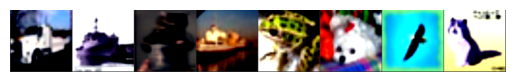

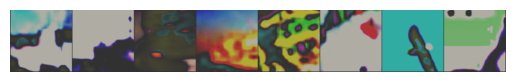

In [9]:
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    # Rescale pixel values to the range [0, 1]
    npimg = npimg*train_means.numpy() + train_stds.numpy()
    plt.imshow(npimg)
    plt.axis('off')
    plt.show()

# Get a batch of images
dataiter = iter(train_loader)

# Display 10 first images with Transformations
images, labels = next(dataiter)
selected_images_transformed = transform_augmented(images[:8])
imshow(torchvision.utils.make_grid(images[:8]))
imshow(torchvision.utils.make_grid(selected_images_transformed))


## Contrastive Model

Import necessary libraries

In [10]:
import torch.nn as nn
from torch.nn.functional import cosine_similarity
import torchvision.transforms.functional as TF
import torch.optim as optim
from tqdm import tqdm

Define the contrastive loss

In [11]:
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2, z_list):
        # Calculate cosine similarity
        similarity_pair = cosine_similarity(z1, z2, dim=-1) / self.temperature

        # Calculate the cosine similarity for each pair of z1 and... but not z1 and z1
        similarities = torch.stack([cosine_similarity(z1, rep, dim=-1) / self.temperature for rep in z_list if not torch.equal(rep, z1)])
        
        if similarities.numel() == 0:
            return torch.tensor(0.0, device=z1.device, requires_grad=True)
        
        # Numerator is exp(similarity_pair)
        exp_similarity = torch.exp(similarity_pair)

        # Denominator is sum(exp(list_similarity_pair))
        exp_similarities = torch.sum(torch.exp(similarities))

        # Apply log-sum-exp trick
        loss = -torch.log(exp_similarity / (exp_similarities + exp_similarity))
        
        if torch.isnan(loss):
            return torch.tensor(0.0, device=z1.device, requires_grad=True)
            
        return torch.mean(loss)  # Compute the mean of the loss

Define the Siamese network

In [12]:
class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.base_model = base_model


    def forward(self, x1, x2):
        z1 = self.base_model(x1)
        z2 = self.base_model(x2)
        return z1, z2

Define the ResNet18-based model

In [13]:
class SimpleResNet(nn.Module):
    def __init__(self):
        super(SimpleResNet, self).__init__()
        self.resnet = torchvision.models.resnet18()
        self.resnet.fc = nn.Identity()

    def forward(self, x):
        return self.resnet(x)

## Initialization

Initialize the model, optimizer, and contrastive loss

In [15]:
model = SiameseNetwork(SimpleResNet())
optimizer = optim.Adam(model.parameters(), lr=1)
criterion = ContrastiveLoss()

Training parameters

In [16]:
%%capture
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

## Traning loop

In [15]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for i, data in enumerate(tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')):

        images, _ = data
        images = images.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Initialize total loss for the batch
        batch_loss = torch.tensor(0.0, device=device, requires_grad=True)

        # Create tuples of transformed images for each image of the batch and put all the zk, zk+1 in a list (feed forward network)
        zk_list = []
        for image in images:
            transformed_image1 = transform_augmented(image).to(device)
            transformed_image2 = transform_augmented(image).to(device)

            z1, z2 = model(transformed_image1.unsqueeze(0), transformed_image2.unsqueeze(0))
            zk_list.append(z1)
            zk_list.append(z2)
            

        # Process each image in the batch
        for i in range(0, len(zk_list), 2):
            # Calculate loss for both the first transformed image and second
            loss1 = criterion(zk_list[i], zk_list[i+1], zk_list)
            loss2 = criterion(zk_list[i+1], zk_list[i], zk_list)
            batch_loss = batch_loss + (loss1 + loss2)
        
        # Backward pass
        batch_loss.backward()

        # Update weights after processing the entire batch
        optimizer.step()

        total_loss += batch_loss.item() / len(images)

    average_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}')
    # if epoch % 10 == 0:
    #     torch.save(model.base_model.state_dict(), f'models/model_weights_epoch_{epoch + 1}.pth')

print('Training finished.')

Epoch 1/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.48it/s]


Epoch 1/100, Loss: 3.895301345062256


Epoch 2/100: 100%|██████████| 1250/1250 [04:40<00:00,  4.46it/s]


Epoch 2/100, Loss: 3.5259346172332764


Epoch 3/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.47it/s]


Epoch 3/100, Loss: 3.3805721887588502


Epoch 4/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.51it/s]


Epoch 4/100, Loss: 3.2575387228965758


Epoch 5/100: 100%|██████████| 1250/1250 [04:40<00:00,  4.46it/s]


Epoch 5/100, Loss: 3.1715917777061464


Epoch 6/100: 100%|██████████| 1250/1250 [04:40<00:00,  4.45it/s]


Epoch 6/100, Loss: 3.079260362815857


Epoch 7/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.48it/s]


Epoch 7/100, Loss: 2.9753774585723876


Epoch 8/100: 100%|██████████| 1250/1250 [04:36<00:00,  4.51it/s]


Epoch 8/100, Loss: 2.9241993049621584


Epoch 9/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.50it/s]


Epoch 9/100, Loss: 2.7859263912200927


Epoch 10/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.51it/s]


Epoch 10/100, Loss: 2.7181441182136536


Epoch 11/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.50it/s]


Epoch 11/100, Loss: 2.6659885850906373


Epoch 12/100: 100%|██████████| 1250/1250 [04:41<00:00,  4.44it/s]


Epoch 12/100, Loss: 2.6297128099441527


Epoch 13/100: 100%|██████████| 1250/1250 [04:40<00:00,  4.46it/s]


Epoch 13/100, Loss: 2.591546292209625


Epoch 14/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.48it/s]


Epoch 14/100, Loss: 2.5667735915184022


Epoch 15/100: 100%|██████████| 1250/1250 [04:42<00:00,  4.43it/s]


Epoch 15/100, Loss: 2.516797407627106


Epoch 16/100: 100%|██████████| 1250/1250 [04:42<00:00,  4.43it/s]


Epoch 16/100, Loss: 2.521137638282776


Epoch 17/100: 100%|██████████| 1250/1250 [04:41<00:00,  4.44it/s]


Epoch 17/100, Loss: 2.4908953058242798


Epoch 18/100: 100%|██████████| 1250/1250 [04:41<00:00,  4.44it/s]


Epoch 18/100, Loss: 2.474708415699005


Epoch 19/100: 100%|██████████| 1250/1250 [04:40<00:00,  4.46it/s]


Epoch 19/100, Loss: 2.464541166687012


Epoch 20/100: 100%|██████████| 1250/1250 [04:41<00:00,  4.45it/s]


Epoch 20/100, Loss: 2.4780483479499815


Epoch 21/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.50it/s]


Epoch 21/100, Loss: 2.4370053997039793


Epoch 22/100: 100%|██████████| 1250/1250 [04:41<00:00,  4.45it/s]


Epoch 22/100, Loss: 2.4310429270744325


Epoch 23/100: 100%|██████████| 1250/1250 [04:38<00:00,  4.49it/s]


Epoch 23/100, Loss: 2.390879981613159


Epoch 24/100: 100%|██████████| 1250/1250 [04:41<00:00,  4.44it/s]


Epoch 24/100, Loss: 2.407426428222656


Epoch 25/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.47it/s]


Epoch 25/100, Loss: 2.3865723105430603


Epoch 26/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.51it/s]


Epoch 26/100, Loss: 2.3629248799324034


Epoch 27/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.47it/s]


Epoch 27/100, Loss: 2.335656368255615


Epoch 28/100: 100%|██████████| 1250/1250 [04:36<00:00,  4.52it/s]


Epoch 28/100, Loss: 2.337896802520752


Epoch 29/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.48it/s]


Epoch 29/100, Loss: 2.3379369875907896


Epoch 30/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.51it/s]


Epoch 30/100, Loss: 2.3209368504524233


Epoch 31/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.51it/s]


Epoch 31/100, Loss: 2.332023588371277


Epoch 32/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.51it/s]


Epoch 32/100, Loss: 2.31532199382782


Epoch 33/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.51it/s]


Epoch 33/100, Loss: 2.2789461935043334


Epoch 34/100: 100%|██████████| 1250/1250 [04:38<00:00,  4.49it/s]


Epoch 34/100, Loss: 2.285486414051056


Epoch 35/100: 100%|██████████| 1250/1250 [04:41<00:00,  4.43it/s]


Epoch 35/100, Loss: 2.2645598360061645


Epoch 36/100: 100%|██████████| 1250/1250 [04:40<00:00,  4.45it/s]


Epoch 36/100, Loss: 2.2519189250946043


Epoch 37/100: 100%|██████████| 1250/1250 [04:40<00:00,  4.46it/s]


Epoch 37/100, Loss: 2.2379085021018983


Epoch 38/100: 100%|██████████| 1250/1250 [04:38<00:00,  4.49it/s]


Epoch 38/100, Loss: 2.2585824959754945


Epoch 39/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.47it/s]


Epoch 39/100, Loss: 2.259301219177246


Epoch 40/100: 100%|██████████| 1250/1250 [04:40<00:00,  4.45it/s]


Epoch 40/100, Loss: 2.2335234270095827


Epoch 41/100: 100%|██████████| 1250/1250 [04:43<00:00,  4.40it/s]


Epoch 41/100, Loss: 2.243530161190033


Epoch 42/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.48it/s]


Epoch 42/100, Loss: 2.2313207330703735


Epoch 43/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.46it/s]


Epoch 43/100, Loss: 2.216501836013794


Epoch 44/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.48it/s]


Epoch 44/100, Loss: 2.2185227773666383


Epoch 45/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.47it/s]


Epoch 45/100, Loss: 2.2043976187705994


Epoch 46/100: 100%|██████████| 1250/1250 [04:40<00:00,  4.45it/s]


Epoch 46/100, Loss: 2.19272646446228


Epoch 47/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.48it/s]


Epoch 47/100, Loss: 2.196598525619507


Epoch 48/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.51it/s]


Epoch 48/100, Loss: 2.2125623646736146


Epoch 49/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.48it/s]


Epoch 49/100, Loss: 2.181835753917694


Epoch 50/100: 100%|██████████| 1250/1250 [04:40<00:00,  4.46it/s]


Epoch 50/100, Loss: 2.183771637916565


Epoch 51/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.50it/s]


Epoch 51/100, Loss: 2.196334769439697


Epoch 52/100: 100%|██████████| 1250/1250 [04:40<00:00,  4.46it/s]


Epoch 52/100, Loss: 2.180399744319916


Epoch 53/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.47it/s]


Epoch 53/100, Loss: 2.178045308303833


Epoch 54/100: 100%|██████████| 1250/1250 [04:42<00:00,  4.43it/s]


Epoch 54/100, Loss: 2.179741744041443


Epoch 55/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.50it/s]


Epoch 55/100, Loss: 2.1470185665130614


Epoch 56/100: 100%|██████████| 1250/1250 [04:38<00:00,  4.48it/s]


Epoch 56/100, Loss: 2.1432219165802002


Epoch 57/100: 100%|██████████| 1250/1250 [04:36<00:00,  4.52it/s]


Epoch 57/100, Loss: 2.1445112071990966


Epoch 58/100: 100%|██████████| 1250/1250 [04:40<00:00,  4.46it/s]


Epoch 58/100, Loss: 2.1363057293891905


Epoch 59/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.48it/s]


Epoch 59/100, Loss: 2.125670612049103


Epoch 60/100: 100%|██████████| 1250/1250 [04:43<00:00,  4.41it/s]


Epoch 60/100, Loss: 2.143921499347687


Epoch 61/100: 100%|██████████| 1250/1250 [04:38<00:00,  4.48it/s]


Epoch 61/100, Loss: 2.133607962989807


Epoch 62/100: 100%|██████████| 1250/1250 [04:40<00:00,  4.46it/s]


Epoch 62/100, Loss: 2.132536782836914


Epoch 63/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.47it/s]


Epoch 63/100, Loss: 2.1433786394119263


Epoch 64/100: 100%|██████████| 1250/1250 [04:40<00:00,  4.46it/s]


Epoch 64/100, Loss: 2.1340457609176635


Epoch 65/100: 100%|██████████| 1250/1250 [04:38<00:00,  4.48it/s]


Epoch 65/100, Loss: 2.1339694650650025


Epoch 66/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.47it/s]


Epoch 66/100, Loss: 2.1277098829269407


Epoch 67/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.51it/s]


Epoch 67/100, Loss: 2.1083362586021424


Epoch 68/100: 100%|██████████| 1250/1250 [04:40<00:00,  4.46it/s]


Epoch 68/100, Loss: 2.113262126350403


Epoch 69/100: 100%|██████████| 1250/1250 [04:42<00:00,  4.43it/s]


Epoch 69/100, Loss: 2.095241707229614


Epoch 70/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.48it/s]


Epoch 70/100, Loss: 2.1147825359344483


Epoch 71/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.50it/s]


Epoch 71/100, Loss: 2.1110694549560547


Epoch 72/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.50it/s]


Epoch 72/100, Loss: 2.0964809864997864


Epoch 73/100: 100%|██████████| 1250/1250 [04:36<00:00,  4.51it/s]


Epoch 73/100, Loss: 2.0739782841682435


Epoch 74/100: 100%|██████████| 1250/1250 [04:36<00:00,  4.51it/s]


Epoch 74/100, Loss: 2.09232783575058


Epoch 75/100: 100%|██████████| 1250/1250 [04:38<00:00,  4.49it/s]


Epoch 75/100, Loss: 2.093937990951538


Epoch 76/100: 100%|██████████| 1250/1250 [04:38<00:00,  4.48it/s]


Epoch 76/100, Loss: 2.0890871044158934


Epoch 77/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.50it/s]


Epoch 77/100, Loss: 2.0864417961120605


Epoch 78/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.51it/s]


Epoch 78/100, Loss: 2.0951825348854065


Epoch 79/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.50it/s]


Epoch 79/100, Loss: 2.084806174182892


Epoch 80/100: 100%|██████████| 1250/1250 [04:42<00:00,  4.43it/s]


Epoch 80/100, Loss: 2.1070138913154604


Epoch 81/100: 100%|██████████| 1250/1250 [04:38<00:00,  4.49it/s]


Epoch 81/100, Loss: 2.0909636625289916


Epoch 82/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.47it/s]


Epoch 82/100, Loss: 2.1005655603408813


Epoch 83/100: 100%|██████████| 1250/1250 [04:41<00:00,  4.45it/s]


Epoch 83/100, Loss: 2.071996374416351


Epoch 84/100: 100%|██████████| 1250/1250 [04:42<00:00,  4.43it/s]


Epoch 84/100, Loss: 2.0828159475326538


Epoch 85/100: 100%|██████████| 1250/1250 [04:43<00:00,  4.42it/s]


Epoch 85/100, Loss: 2.090448519897461


Epoch 86/100: 100%|██████████| 1250/1250 [04:40<00:00,  4.45it/s]


Epoch 86/100, Loss: 2.062355260658264


Epoch 87/100: 100%|██████████| 1250/1250 [04:38<00:00,  4.48it/s]


Epoch 87/100, Loss: 2.0800796081542967


Epoch 88/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.51it/s]


Epoch 88/100, Loss: 2.0631072934150696


Epoch 89/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.51it/s]


Epoch 89/100, Loss: 2.0615229218482973


Epoch 90/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.50it/s]


Epoch 90/100, Loss: 2.058687296485901


Epoch 91/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.50it/s]


Epoch 91/100, Loss: 2.060003123092651


Epoch 92/100: 100%|██████████| 1250/1250 [04:40<00:00,  4.45it/s]


Epoch 92/100, Loss: 2.0558115544319153


Epoch 93/100: 100%|██████████| 1250/1250 [04:38<00:00,  4.49it/s]


Epoch 93/100, Loss: 2.0589470286369322


Epoch 94/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.47it/s]


Epoch 94/100, Loss: 2.051111362361908


Epoch 95/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.47it/s]


Epoch 95/100, Loss: 2.040264616012573


Epoch 96/100: 100%|██████████| 1250/1250 [04:39<00:00,  4.48it/s]


Epoch 96/100, Loss: 2.043308251476288


Epoch 97/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.51it/s]


Epoch 97/100, Loss: 2.053964349555969


Epoch 98/100: 100%|██████████| 1250/1250 [04:36<00:00,  4.51it/s]


Epoch 98/100, Loss: 2.049929883861542


Epoch 99/100: 100%|██████████| 1250/1250 [04:37<00:00,  4.50it/s]


Epoch 99/100, Loss: 2.0416496950149536


Epoch 100/100: 100%|██████████| 1250/1250 [04:38<00:00,  4.48it/s]

Epoch 100/100, Loss: 2.044849764060974
Training finished.


Save the trained model

In [16]:
torch.save(model.base_model.state_dict(), 'model_clr_100_epochs.pth')

## Learned representations

### TSNE (t-distributed Stochastic Neighbor Embedding)

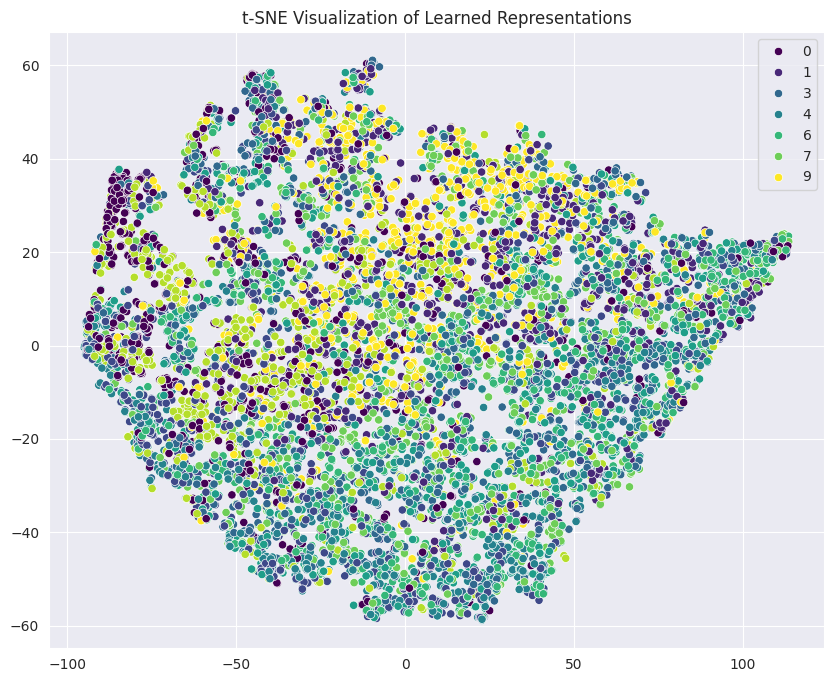

In [17]:
from sklearn.manifold import TSNE
import seaborn as sns


num_visualization_samples = 100
visualization_loader = DataLoader(subset_dataset, batch_size=num_visualization_samples, shuffle=True, num_workers=2)

model.eval()
all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in visualization_loader:
        images = images.to(device)
        features = model.base_model(images)
        all_features.append(features.cpu().numpy())
        all_labels.append(labels.numpy())

all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embedded_features = tsne.fit_transform(all_features)

# Plot the t-SNE embeddings
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedded_features[:, 0], y=embedded_features[:, 1], hue=all_labels, palette='viridis')
plt.title('t-SNE Visualization of Learned Representations')
plt.show()

### Nearest Neighbors Search

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


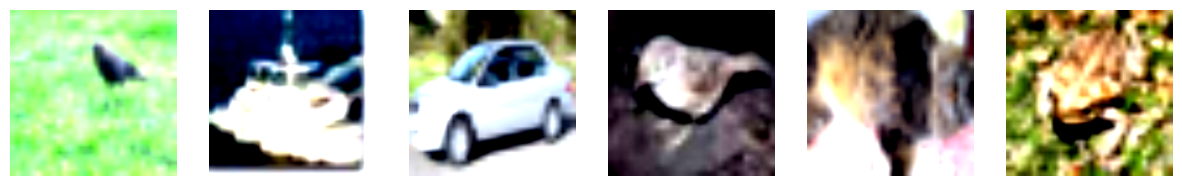

In [18]:
from sklearn.neighbors import NearestNeighbors

num_neighbors_search_samples = 10
neighbors_search_loader = DataLoader(subset_dataset, batch_size=num_neighbors_search_samples, shuffle=True, num_workers=2)

model.eval()
all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in neighbors_search_loader:
        images = images.to(device)
        features = model.base_model(images)
        all_features.append(features.cpu().numpy())
        all_labels.append(labels.numpy())

all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Fit a nearest neighbors model
nn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
nn_model.fit(all_features)

# Query for nearest neighbors for a random sample
query_index = np.random.choice(len(val_dataset))
query_image, query_label = val_dataset[query_index]
query_feature = model.base_model(query_image.unsqueeze(0).to(device)).cpu().detach().numpy().reshape(1, -1)
_, neighbors = nn_model.kneighbors(query_feature)

def visualize_images(images):
    """Visualize a list of images."""
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        axes[i].imshow(np.transpose(images[i]/2+0.5, (1, 2, 0)))
        axes[i].axis('off')

    plt.show()

# Visualize query and its nearest neighbors
visualize_images([query_image] + [val_dataset[i][0] for i in neighbors[0]])


## Classification Head


### Usual MLP

Clear the cache and empty the GPU memory if needed

In [ ]:
torch.cuda.empty_cache()

Define a simple MLP model

In [17]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [18]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define transformation to convert CIFAR-10 images to grayscale
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load CIFAR-10 dataset
train_dataset_mlp = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset_mlp = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define data loaders
batch_size = 128

Files already downloaded and verified
Files already downloaded and verified


In [19]:
# Calculate the mean and std of the subset dataset
train_means_mlp, train_stds_mlp = get_mean_std(train_dataset_mlp)
print(f'Means: {train_means_mlp}')
print(f'Standard deviations: {train_stds_mlp}\n')
val_means_mlp, val_stds_mlp = get_mean_std(test_dataset_mlp)
print(f'Validation means: {val_means_mlp}')
print(f'Validation standard deviations: {val_stds_mlp}')

==> Computing mean and std..
Means: tensor([0.4914, 0.4822, 0.4465])
Standard deviations: tensor([0.2023, 0.1994, 0.2010])

==> Computing mean and std..
Validation means: tensor([0.4942, 0.4851, 0.4504])
Validation standard deviations: tensor([0.2020, 0.1991, 0.2011])


Apply transformations

In [20]:
%%capture
train_dataset_mlp = datasets.CIFAR10(root='./data', train=True, download=True, transform=get_transforms(train_means_mlp,train_stds_mlp))
val_dataset_mlp = datasets.CIFAR10(root='./data', train=False, download=True, transform=get_transforms(val_means_mlp,val_stds_mlp))

# Data Loader
train_loader_mlp = DataLoader(train_dataset_mlp, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader_mlp = DataLoader(val_dataset_mlp, batch_size=batch_size, shuffle=False, num_workers=2)

Define model, criterion, and optimizer

In [21]:
input_size = 224 * 224 * 3  # Size of CIFAR-10 images after flattening
hidden_size = 256
output_size = 10  # Number of classes in CIFAR-10
mlp_model = MLP(input_size, hidden_size, output_size)
mlp_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

num_epochs = 10

Training loop

In [22]:
for epoch in range(num_epochs):
    mlp_model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for i, data in enumerate(tqdm(train_loader_mlp, desc=f'Epoch {epoch + 1}/{num_epochs}')):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = mlp_model(images.view(images.size(0), -1))

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

    average_loss = total_loss / len(train_loader)
    accuracy = correct / total_samples

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}, Accuracy: {accuracy}')

print('Training finished.')

Epoch 1/10: 100%|██████████| 391/391 [00:28<00:00, 13.59it/s]


Epoch 1/10, Loss: 5.452323257064819, Accuracy: 0.30684


Epoch 2/10: 100%|██████████| 391/391 [00:28<00:00, 13.81it/s]


Epoch 2/10, Loss: 1.0613502403259278, Accuracy: 0.39888


Epoch 3/10: 100%|██████████| 391/391 [00:28<00:00, 13.55it/s]


Epoch 3/10, Loss: 0.549143210220337, Accuracy: 0.45944


Epoch 4/10: 100%|██████████| 391/391 [00:29<00:00, 13.31it/s]


Epoch 4/10, Loss: 0.514160632801056, Accuracy: 0.47282


Epoch 5/10: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s]


Epoch 5/10, Loss: 0.5345180750846863, Accuracy: 0.46676


Epoch 6/10: 100%|██████████| 391/391 [00:28<00:00, 13.60it/s]


Epoch 6/10, Loss: 0.5612415117263794, Accuracy: 0.45636


Epoch 7/10: 100%|██████████| 391/391 [00:29<00:00, 13.46it/s]


Epoch 7/10, Loss: 0.5988725337982178, Accuracy: 0.44372


Epoch 8/10: 100%|██████████| 391/391 [00:28<00:00, 13.49it/s]


Epoch 8/10, Loss: 0.6445986505508423, Accuracy: 0.4322


Epoch 9/10: 100%|██████████| 391/391 [00:28<00:00, 13.72it/s]


Epoch 9/10, Loss: 0.6812190964698791, Accuracy: 0.42154


Epoch 10/10: 100%|██████████| 391/391 [00:29<00:00, 13.25it/s]

Epoch 10/10, Loss: 0.7083056594848632, Accuracy: 0.42348
Training finished.


Evaluate on the test set

In [23]:
mlp_model.eval()
correct = 0
total_samples = 0

with torch.no_grad():
    for data in tqdm(test_loader_mlp, desc='Testing'):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = mlp_model(images.view(images.size(0), -1))
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

accuracy = correct / total_samples
print(f'Test Accuracy: {accuracy}')

Testing: 100%|██████████| 79/79 [00:06<00:00, 12.85it/s]

Test Accuracy: 0.3875


Save the MLP model weights

In [24]:
torch.save(mlp_model.state_dict(), 'model_mlp.pth')

#### Our SimCLR model with MLP Head

In [25]:
clr_base_model = SimpleResNet()
clr_base_model.load_state_dict(torch.load('model_clr_100_epochs.pth'))
clr_base_model.eval()

SimpleResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Define the MLP head for classification

In [26]:
class MLPHead(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPHead, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the full model with contrastive feature extractor and MLP head
class ContrastiveMLPModel(nn.Module):
    def __init__(self, feature_extractor, mlp_head):
        super(ContrastiveMLPModel, self).__init__()
        self.base_model = feature_extractor
        self.mlp_model = mlp_head

    def forward(self, x):
        features = self.base_model(x)
        return self.mlp_model(features.view(features.size(0), -1))

Parameters, model, optimizer, and loss function

In [27]:
# Output size of base model: torch.Size([1, 512])
input_size_for_mlp = 512

# Define the MLP head for classification
mlp_head = MLPHead(input_size_for_mlp, hidden_size=256, num_classes=output_size)

# Combine the feature extractor and MLP head into the full model
contrastive_mlp_model = ContrastiveMLPModel(clr_base_model, mlp_head)
contrastive_mlp_model.base_model.requires_grad = False

# Define the optimizer
mlp_lr = 0.001
optimizer = torch.optim.Adam(contrastive_mlp_model.mlp_model.parameters(), lr=mlp_lr)
criterion = nn.CrossEntropyLoss()

# Define the training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
contrastive_mlp_model.to(device)

ContrastiveMLPModel(
  (base_model): SimpleResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

Training loop

In [28]:
for epoch in range(num_epochs):
    contrastive_mlp_model.train()
    total_classification_loss = 0

    for i, data in enumerate(tqdm(train_loader_mlp, desc=f'Epoch {epoch + 1}/{num_epochs}')):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients only for the parameters that require grad (MLP head)
        contrastive_mlp_model.zero_grad()

        # Forward pass
        predictions = contrastive_mlp_model(images)

        # Calculate classification loss using CrossEntropyLoss
        classification_loss = criterion(predictions, labels)
        total_classification_loss += classification_loss.item()


        # Backward pass and update weights for the MLP head only
        classification_loss.backward()
        optimizer.step()

    average_classification_loss = total_classification_loss / len(train_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, Classification Loss: {average_classification_loss}')

print('Training finished.')

Epoch 1/10: 100%|██████████| 391/391 [01:32<00:00,  4.23it/s]


Epoch 1/10, Classification Loss: 0.5220207430839539


Epoch 2/10: 100%|██████████| 391/391 [01:32<00:00,  4.23it/s]


Epoch 2/10, Classification Loss: 0.4728517897605896


Epoch 3/10: 100%|██████████| 391/391 [01:32<00:00,  4.23it/s]


Epoch 3/10, Classification Loss: 0.45939055109024046


Epoch 4/10: 100%|██████████| 391/391 [01:32<00:00,  4.23it/s]


Epoch 4/10, Classification Loss: 0.45049768953323366


Epoch 5/10: 100%|██████████| 391/391 [01:32<00:00,  4.22it/s]


Epoch 5/10, Classification Loss: 0.44428594942092897


Epoch 6/10: 100%|██████████| 391/391 [01:32<00:00,  4.22it/s]


Epoch 6/10, Classification Loss: 0.43954253396987913


Epoch 7/10: 100%|██████████| 391/391 [01:32<00:00,  4.22it/s]


Epoch 7/10, Classification Loss: 0.4359732144355774


Epoch 8/10: 100%|██████████| 391/391 [01:32<00:00,  4.23it/s]


Epoch 8/10, Classification Loss: 0.4312116488456726


Epoch 9/10: 100%|██████████| 391/391 [01:32<00:00,  4.23it/s]


Epoch 9/10, Classification Loss: 0.4292935785293579


Epoch 10/10: 100%|██████████| 391/391 [01:32<00:00,  4.23it/s]

Epoch 10/10, Classification Loss: 0.4269687159538269
Training finished.


Evaluate on the test set

In [29]:
contrastive_mlp_model.eval()
correct = 0
total_samples = 0

with torch.no_grad():
    for data in tqdm(test_loader_mlp, desc='Testing'):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = contrastive_mlp_model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

accuracy = correct / total_samples
print(f'Test Accuracy: {accuracy}')

Testing: 100%|██████████| 79/79 [00:07<00:00, 10.63it/s]

Test Accuracy: 0.4863


### Using a more complex architecture of FC layers

Defining the Architecture of the neural network

In [30]:
class ComplexFC(nn.Module):
    def __init__(self, input_channels=3, input_size=(224, 224), num_classes=10):
        super(ComplexFC, self).__init__()
        self.input_channels = input_channels
        self.input_size = input_size
        self.fc1 = nn.Linear(input_channels * input_size[0] * input_size[1], 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input assuming it's of shape [batch_size, input_channels, height, width]
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Transformations and Dataset

In [31]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define transformation to convert CIFAR-10 images to grayscale
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load CIFAR-10 dataset
train_dataset_fc = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset_fc = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define data loaders
batch_size = 64

Files already downloaded and verified
Files already downloaded and verified


Calculating means and stds

In [32]:
# Calculate the mean and std of the subset dataset
train_means_fc, train_stds_fc = get_mean_std(train_dataset_fc)
print(f'Means: {train_means_fc}')
print(f'Standard deviations: {train_stds_fc}\n')
val_means_fc, val_stds_fc = get_mean_std(test_dataset_fc)
print(f'Validation means: {val_means_fc}')
print(f'Validation standard deviations: {val_stds_fc}')

==> Computing mean and std..
Means: tensor([0.4914, 0.4822, 0.4465])
Standard deviations: tensor([0.2023, 0.1994, 0.2010])

==> Computing mean and std..
Validation means: tensor([0.4942, 0.4851, 0.4504])
Validation standard deviations: tensor([0.2020, 0.1991, 0.2011])


Applying transformations

In [33]:
%%capture
# Apply transformations
train_dataset_fc = datasets.CIFAR10(root='./data', train=True, download=True, transform=get_transforms(train_means_fc,train_stds_fc))
val_dataset_fc = datasets.CIFAR10(root='./data', train=False, download=True, transform=get_transforms(val_means_fc,val_stds_fc))

# Data Loader
train_loader_fc = DataLoader(train_dataset_fc, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader_fc = DataLoader(val_dataset_fc, batch_size=batch_size, shuffle=False, num_workers=2)

Defining the model, optimizer, and loss function

In [34]:
# Define model, criterion, and optimizer
num_classes = 10  # Number of classes in CIFAR-10
fc_model = ComplexFC(input_channels=3, input_size=(224, 224), num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fc_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fc_model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

Traning loop

In [35]:
for epoch in range(num_epochs):
    fc_model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for i, data in enumerate(tqdm(train_loader_fc, desc=f'Epoch {epoch + 1}/{num_epochs}')):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = fc_model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

    average_loss = total_loss / len(train_loader_fc)
    accuracy = correct / total_samples

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}, Accuracy: {accuracy}')

print('Training finished.')

Epoch 1/10: 100%|██████████| 782/782 [00:29<00:00, 26.34it/s]


Epoch 1/10, Loss: 1.7963390856447732, Accuracy: 0.36648


Epoch 2/10: 100%|██████████| 782/782 [00:29<00:00, 26.89it/s]


Epoch 2/10, Loss: 1.6391650677641945, Accuracy: 0.41988


Epoch 3/10: 100%|██████████| 782/782 [00:29<00:00, 26.54it/s]


Epoch 3/10, Loss: 1.5780685742187988, Accuracy: 0.4431


Epoch 4/10: 100%|██████████| 782/782 [00:29<00:00, 26.82it/s]


Epoch 4/10, Loss: 1.531396267359214, Accuracy: 0.46244


Epoch 5/10: 100%|██████████| 782/782 [00:29<00:00, 26.82it/s]


Epoch 5/10, Loss: 1.5044375595534245, Accuracy: 0.4735


Epoch 6/10: 100%|██████████| 782/782 [00:29<00:00, 26.66it/s]


Epoch 6/10, Loss: 1.4774681383081714, Accuracy: 0.48122


Epoch 7/10: 100%|██████████| 782/782 [00:29<00:00, 26.75it/s]


Epoch 7/10, Loss: 1.4611272255478003, Accuracy: 0.48808


Epoch 8/10: 100%|██████████| 782/782 [00:29<00:00, 26.83it/s]


Epoch 8/10, Loss: 1.4331544579752267, Accuracy: 0.49766


Epoch 9/10: 100%|██████████| 782/782 [00:29<00:00, 26.68it/s]


Epoch 9/10, Loss: 1.4167540324923327, Accuracy: 0.5032


Epoch 10/10: 100%|██████████| 782/782 [00:29<00:00, 26.38it/s]

Epoch 10/10, Loss: 1.4012743357349844, Accuracy: 0.5107
Training finished.


Evaluating on the test set

In [36]:
# Evaluate on the test set
fc_model.eval()
correct = 0
total_samples = 0

with torch.no_grad():
    for data in tqdm(test_loader_fc, desc='Testing'):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = fc_model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

accuracy = correct / total_samples
print(f'Test Accuracy: {accuracy}')

Testing: 100%|██████████| 157/157 [00:06<00:00, 26.00it/s]

Test Accuracy: 0.53


In [37]:
torch.save(fc_model.state_dict(), 'model_fc.pth')

#### Our SimCLR model with CNN Head

Loading the SimCLR model

In [48]:
clr_base_model_for_fc = SimpleResNet()
clr_base_model_for_fc.load_state_dict(torch.load('model_clr_100_epochs.pth'))
clr_base_model_for_fc.eval()

SimpleResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Defining the CNN Head

In [49]:
class FCHead(nn.Module):
    def __init__(self, input_size=512, num_classes=10):
        super(FCHead, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(self.input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class ContrastiveFCModel(nn.Module):
    def __init__(self, feature_extractor, fc_head):
        super(ContrastiveFCModel, self).__init__()
        self.base_model = feature_extractor
        self.fc_model = fc_head

    def forward(self, x):
        features = self.base_model(x)
        return self.fc_model(features.view(features.size(0), -1))

Parameters, model, optimizer, and loss function

In [50]:
# Define the CNN head for classification
fc_head = FCHead(input_size=512, num_classes=num_classes)

# Combine the feature extractor and MLP head into the full model
contrastive_fc_model = ContrastiveFCModel(clr_base_model_for_fc, fc_head)
contrastive_fc_model.base_model.requires_grad = False

# Define the optimizer
mlp_lr = 0.001
optimizer = torch.optim.Adam(contrastive_fc_model.fc_model.parameters(), lr=mlp_lr)
criterion = nn.CrossEntropyLoss()

# Define the training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
contrastive_fc_model.to(device)

ContrastiveFCModel(
  (base_model): SimpleResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [51]:
# Training loop
for epoch in range(num_epochs):
    contrastive_fc_model.train()
    total_classification_loss = 0

    for i, data in enumerate(tqdm(train_loader_fc, desc=f'Epoch {epoch + 1}/{num_epochs}')):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients only for the parameters that require grad (FC head)
        contrastive_fc_model.zero_grad()

        # Forward pass
        predictions = contrastive_fc_model(images)

        # Calculate classification loss using CrossEntropyLoss
        classification_loss = criterion(predictions, labels)
        total_classification_loss += classification_loss.item()

        # Backward pass and update weights for the FC head only
        classification_loss.backward()
        optimizer.step()

    average_classification_loss = total_classification_loss / len(train_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, Classification Loss: {average_classification_loss}')

print('Training finished.')

Epoch 1/10: 100%|██████████| 782/782 [01:33<00:00,  8.35it/s]


Epoch 1/10, Classification Loss: 1.0577284106254579


Epoch 2/10: 100%|██████████| 782/782 [01:34<00:00,  8.31it/s]


Epoch 2/10, Classification Loss: 1.0021654881477355


Epoch 3/10: 100%|██████████| 782/782 [01:33<00:00,  8.32it/s]


Epoch 3/10, Classification Loss: 0.9813038632392883


Epoch 4/10: 100%|██████████| 782/782 [01:34<00:00,  8.26it/s]


Epoch 4/10, Classification Loss: 0.97359410572052


Epoch 5/10: 100%|██████████| 782/782 [01:34<00:00,  8.26it/s]


Epoch 5/10, Classification Loss: 0.9641896392822266


Epoch 6/10: 100%|██████████| 782/782 [01:34<00:00,  8.29it/s]


Epoch 6/10, Classification Loss: 0.9577692916870117


Epoch 7/10: 100%|██████████| 782/782 [01:33<00:00,  8.33it/s]


Epoch 7/10, Classification Loss: 0.9540761549949646


Epoch 8/10: 100%|██████████| 782/782 [01:33<00:00,  8.36it/s]


Epoch 8/10, Classification Loss: 0.9469254410743714


Epoch 9/10: 100%|██████████| 782/782 [01:33<00:00,  8.36it/s]


Epoch 9/10, Classification Loss: 0.942102390384674


Epoch 10/10: 100%|██████████| 782/782 [01:33<00:00,  8.36it/s]

Epoch 10/10, Classification Loss: 0.9394916420936584
Training finished.


Evaluating on the test set

In [52]:
# Evaluate on the test set
contrastive_fc_model.eval()
correct = 0
total_samples = 0

with torch.no_grad():
    for data in tqdm(test_loader_fc, desc='Testing'):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = contrastive_fc_model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

accuracy = correct / total_samples
print(f'Test Accuracy: {accuracy}')

Testing: 100%|██████████| 157/157 [00:07<00:00, 20.24it/s]

Test Accuracy: 0.4794
